In [ ]:
!pip install git+https://github.com/openai/whisper.git
!pip install datasets transformers torchaudio jiwer

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-hs6ao3fn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-hs6ao3fn
  Resolved https://github.com/openai/whisper.git to commit dd985ac4b90cafeef8712f2998d62c59c3e62d22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 642.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("commonVoice_21.h5", "r") as f:
    audio_arrays = [np.array(arr) for arr in f["audio"]]
    sentences = [s.decode("utf-8") if isinstance(s, bytes) else s for s in f["sentence"]]
    sampling_rates = np.array(f["sampling_rate"])

# Example: create a list of dicts (like HuggingFace Dataset)
dataset = [
    {
        "audio": {
            "array": audio_arrays[i],
            "sampling_rate": int(sampling_rates[i])
        },
        "sentence": sentences[i]
    }
    for i in range(len(sentences))
]

dataset

[{'audio': {'array': array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           1.0603580e-07,  2.5609751e-08, -9.9073276e-08], dtype=float32),
   'sampling_rate': 32000},
  'sentence': 'Thất bại là mẹ thành công'},
 {'audio': {'array': array([ 0.0000000e+00,  2.0928166e-14,  5.6149306e-15, ...,
          -1.8045277e-08, -3.0225880e-08, -2.9119658e-08], dtype=float32),
   'sampling_rate': 32000},
  'sentence': 'Cái Thảo nó chết rồi làm gì có mà gọi lắm thế'},
 {'audio': {'array': array([ 0.0000000e+00,  7.8083902e-16,  3.2646045e-15, ...,
          -1.5651262e-08, -2.0897527e-08,  5.9226181e-08], dtype=float32),
   'sampling_rate': 32000},
  'sentence': 'Dẫu cuộc đời dù có phải đổi thay'},
 {'audio': {'array': array([ 0.0000000e+00, -4.6813092e-17, -1.0353724e-17, ...,
          -2.6652060e-08, -1.8078072e-07, -1.9993468e-07], dtype=float32),
   'sampling_rate': 32000},
  'sentence': 'Mẹ vẫn lo âu'},
 {'audio': {'array': array([ 0.0000000e+00, -4.6121215e-15,  4.3406898e-15

Thất bại là mẹ thành công


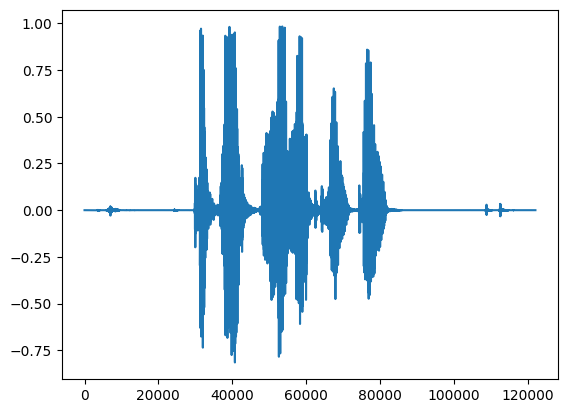

In [ ]:
print(sentences[0])
plt.plot(audio_arrays[0])
plt.show()

In [ ]:
import IPython.display as ipd

# Play audio with the correct sampling rate
ipd.Audio(audio_arrays[0], rate=sampling_rates[0])

In [ ]:
import librosa

# Whisper expects 16kHz audio
TARGET_SR = 16000

whisper_dataset = []
for i in range(len(audio_arrays)):
    # Resample if needed
    arr = audio_arrays[i]
    orig_sr = int(sampling_rates[i])
    if orig_sr != TARGET_SR:
        arr = librosa.resample(arr, orig_sr=orig_sr, target_sr=TARGET_SR)
    # Normalize to [-1, 1] if not already
    arr = arr.astype(np.float32)
    max_val = np.max(np.abs(arr))
    if max_val > 0:
        arr = arr / max_val
    whisper_dataset.append({
        "audio": arr,
        "sampling_rate": TARGET_SR,
        "sentence": sentences[i]
    })

# Example: check the first sample
print(whisper_dataset[0]["audio"].shape, whisper_dataset[0]["sampling_rate"], whisper_dataset[0]["sentence"])

(61056,) 16000 Thất bại là mẹ thành công


In [ ]:
from transformers import WhisperProcessor
import librosa

model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)
TARGET_SR = 16000

def preprocess_whisper(example):
    # Resample audio if needed
    arr = example["audio"]["array"]
    orig_sr = example["audio"]["sampling_rate"]
    if orig_sr != TARGET_SR:
        arr = librosa.resample(arr, orig_sr=orig_sr, target_sr=TARGET_SR)
    # Feature extraction
    input_features = processor.feature_extractor(arr, sampling_rate=TARGET_SR, return_tensors="pt").input_features[0]
    # Tokenization
    labels = processor.tokenizer(example["sentence"], return_tensors="pt").input_ids[0]
    return {
        "input_features": input_features,
        "labels": labels
    }

# Map preprocessing to your dataset
processed_dataset = [preprocess_whisper(sample) for sample in dataset]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset as HFDataset

# processed_dataset is a list of dicts with 'input_features' and 'labels'
hf_dataset = HFDataset.from_dict({
    "input_features": [d["input_features"].numpy() for d in processed_dataset],
    "labels": [d["labels"].numpy() for d in processed_dataset]
})

In [ ]:
import torch

def data_collator(batch):
    input_features = torch.stack([torch.tensor(x["input_features"]) for x in batch])
    labels = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x["labels"]) for x in batch],
        batch_first=True,
        padding_value=processor.tokenizer.pad_token_id
    )
    return {"input_features": input_features, "labels": labels}

In [ ]:
from transformers import TrainingArguments, Trainer, WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(model_name)
# Freeze all the parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers of the decoder (e.g., the last 2 layers)
# You might need to inspect the model's architecture to target specific layers
# This is a general example and might need adjustment based on the model structure
num_decoder_layers_to_unfreeze = 2
for i, layer in enumerate(model.model.decoder.layers[::-1]):
    if i < num_decoder_layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True
    else:
        break

# You might also want to unfreeze the output layer(s)
for param in model.proj_out.parameters():
     param.requires_grad = True

# Verify which parameters are trainable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name}")

training_args = TrainingArguments(
    output_dir="./whisper-vi-finetuned",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2000,
    logging_steps=10,
    save_steps=500,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset,
    data_collator=data_collator,
    tokenizer=processor.tokenizer
)

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Trainable parameter: model.decoder.embed_tokens.weight
Trainable parameter: model.decoder.layers.10.self_attn.k_proj.weight
Trainable parameter: model.decoder.layers.10.self_attn.v_proj.weight
Trainable parameter: model.decoder.layers.10.self_attn.v_proj.bias
Trainable parameter: model.decoder.layers.10.self_attn.q_proj.weight
Trainable parameter: model.decoder.layers.10.self_attn.q_proj.bias
Trainable parameter: model.decoder.layers.10.self_attn.out_proj.weight
Trainable parameter: model.decoder.layers.10.self_attn.out_proj.bias
Trainable parameter: model.decoder.layers.10.self_attn_layer_norm.weight
Trainable parameter: model.decoder.layers.10.self_attn_layer_norm.bias
Trainable parameter: model.decoder.layers.10.encoder_attn.k_proj.weight
Trainable parameter: model.decoder.layers.10.encoder_attn.v_proj.weight
Trainable parameter: model.decoder.layers.10.encoder_attn.v_proj.bias
Trainable parameter: model.decoder.layers.10.encoder_attn.q_proj.weight
Trainable parameter: model.decoder

<ipython-input-15-553302418>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,5.773800
20,5.774600
30,5.630000
40,5.363400
50,5.303200
60,5.265200
70,5.208600
80,5.015000
90,4.862900
100,4.507800


TrainOutput(global_step=2000, training_loss=0.4766069117999868, metrics={'train_runtime': 6172.8093, 'train_samples_per_second': 5.184, 'train_steps_per_second': 0.324, 'total_flos': 9.13863387193344e+18, 'train_loss': 0.4766069117999868, 'epoch': 333.3333333333333})

# Inference

In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Load processor and model from checkpoint
checkpoint_path = "/content/whisper-vi-finetuned/checkpoint-2000"

# processor = WhisperProcessor.from_pretrained(checkpoint_path)
model = WhisperForConditionalGeneration.from_pretrained(checkpoint_path)
model.generation_config.language = "vi"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

In [ ]:
model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)

In [ ]:
import torch
import torchaudio

# Load and resample audio to 16kHz
def load_audio(path):
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    return waveform.squeeze()

audio_input = load_audio("21011003_calm_down_05.wav")

In [ ]:
# Extract input features
inputs = processor(audio_input, sampling_rate=16000, return_tensors="pt")

In [ ]:
print(model.config.forced_decoder_ids)

[[1, 50259], [2, 50359], [3, 50363]]


In [ ]:
input_features = inputs.input_features.to(model.device)
with torch.no_grad():
    pred_ids = model.generate(input_features)

transcription = processor.batch_decode(pred_ids, skip_special_tokens=True)[0]
print(transcription)

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensL

 Việt Nam ơi
